# Hate Speech Detection with Sentinel: Building and Evaluating a Robust Detection Model

This example demonstrates how to use the Sentinel library to build a robust hate speech detection model with minimal examples and evaluate it across different content sources. Sentinel excels at detecting extremely rare classes of harmful content using contrastive learning principles.

## Data Sources and Methodology

### Training Data:
- **Positive Examples (~1,500)**: Extracted from the Southern Poverty Law Center's (SPLC) Extremist Files database, specifically from "In Their Own Words" sections that contain direct quotes from individuals or groups identified as extremists. These quotes represent authentic examples of hate speech from various extremist ideologies.
- **Negative Examples (~15,000)**: Obtained from the Lex Fridman podcast dataset, which contains neutral, intellectual discussions. The 10:1 ratio of negative-to-positive examples reflects the typical imbalance in real-world content.

### Evaluation Data:
- **Test Positives**: Podcast transcripts, known for controversial and potentially harmful content.
- **Test Negatives**: Different episodes from Lex Fridman's podcast, providing a contrast to potentially harmful content.

### Workflow:
1. **Data Preparation**: Extract extremist quotes from SPLC and neutral content from conversational datasets. Segment longer texts into manageable chunks of 512 tokens with 128-token stride.
2. **Model Building**: Create embeddings of both positive and negative examples using the MiniLM-L6-v2 model, then build a Sentinel index to measure semantic similarity to the hate speech class.
3. **Evaluation**: Score content at both segment and episode levels using contrastive learning and statistical measures like skewness to identify patterns across observations.
4. **Analysis**: Compare the distribution of hate speech affinity scores between a controversial podcast and Lex Fridman content to validate the model's effectiveness.

This approach demonstrates how Sentinel can detect rare patterns of concerning content with limited training examples, focusing on the semantic similarity to known extremist language rather than requiring extensive labeled datasets.

## Setup

Before running this notebook, ensure you have installed the example dependencies and registered the Poetry environment as a Jupyter kernel. See the project README for details.

### Downloading the data

There is a script for downloading the Extremist Files from the Southern Poverty Law Center (SPLC) website, the neutral dataset, and the controversial podcast examples

In [1]:
import os
import glob
import pandas as pd
from sentinel import SentinelLocalIndex
import re
from pathlib import Path
from tqdm.notebook import tqdm
import random
import pandas as pd
from tqdm.notebook import tqdm
import os
import requests
from datasets.utils.file_utils import get_datasets_user_agent

In [2]:
from transformers import AutoTokenizer

# Use MiniLM tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def segment_text(text, max_tokens=512, stride=128):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    segments = []
    start = 0
    while start < len(tokens):
        end = start + max_tokens
        segment_tokens = tokens[start:end]
        segment_text = tokenizer.decode(segment_tokens)
        segments.append(segment_text)
        if end >= len(tokens):
            break
        start += stride
    return segments

## Download and parse the positive example
Let's build the hate speech dataset using the example from Southern Poverty Law Center's (SPLC)


In [3]:
# Define function to extract "In Their Own Words" sections from markdown files using line-by-line parsing
def extract_in_their_own_words(md_file):
    try:
        # Extract filename to use as identifier
        filename = Path(md_file).stem
        
        # Read the file line by line
        with open(md_file, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        
        # Simple pattern to match "In his/her/their own words" headers
        own_words_pattern = re.compile(r'^(?:#+\s*)?[Ii]n (?:[Hh](?:is|er)|[Tt]heir) [Oo]wn [Ww]ords:?')
        background_pattern = re.compile(r'^(?:#+\s*)?(Background|BACKGROUND):?\s*$')
        
        # Variables to track state
        in_own_words_section = False
        current_section_lines = []
        all_paragraphs = []
        sections_found = 0
        
        # Process each line
        for i, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue

            # Check if this is an "In their own words" heading
            starting_own_words_section = own_words_pattern.match(line)

            if starting_own_words_section:
                if in_own_words_section:
                    # This shouldnot happen. Print useful debug information
                    print(f"Warning: Found another 'In Their Own Words' section in {md_file} at line {i + 1}, but already in one.")
                    print(f"Previous section lines: {current_section_lines}")
                    current_section_lines = []  # Reset current section lines
                else:
                    in_own_words_section = True
                    sections_found += 1
                # Skip this line (heading) and start collecting content                
                continue
            
            # Check if we've reached a "Background" or another header section
            if in_own_words_section and (background_pattern.match(line) or (line.startswith('#') and len(line) > 1)):
                # Process the current section
                paragraphs = process_section(current_section_lines)
                all_paragraphs.extend({'filename': filename, 'paragraph': p} for p in paragraphs)
                current_section_lines = []
                in_own_words_section = False
                continue
            
            # If we're in a section, collect the line
            if in_own_words_section:
                current_section_lines.append(line)
        
        # Don't forget to process the last section if we're still in one at the end of the file
        if current_section_lines:
            if not in_own_words_section:
                print(f"Warning: Reached end of file in {md_file} without closing 'In Their Own Words' section.")
                print(f"Collected lines: {current_section_lines}")
            paragraphs = process_section(current_section_lines)
            all_paragraphs.extend({'filename': filename, 'paragraph': p} for p in paragraphs)
        
        # if sections_found > 0:
        #     print(f"Processing {md_file}: found {sections_found} 'In Their Own Words' sections")
        
        return all_paragraphs
    except Exception as e:
        print(f"Error processing {md_file}: {e}")
        return []

# Helper function to process collected section lines into paragraphs
def process_section(lines):
    if not lines:
        return []
    
    # Skip if the first line starts with "Background" (table of contents)
    if lines and lines[0].strip().startswith("Background"):
        return []
    
    quotes = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Citation patterns - typically start with a dash, quote mark, or include a year/reference
        is_citation = False
        
        # Patterns that strongly indicate a citation rather than a quote
        if (
            re.match(r'^(—|â|\xa0?—|\xa0?–|"|â\x80\x94)$', line) or
            # Lines ending with a year
            re.search(r' \d{4}\.?\s*$', line)
        ) and len(line) < 100:
            # If it looks like a citation, skip it
            is_citation = True
        
        # If not a citation, add as a quote
        if not is_citation:
            quotes.append(line)
    
    # Filter out very short quotes (likely fragments)
    quotes = [q for q in quotes if len(q) > 10]
    
    return quotes

# Find all markdown files in the SPLC Extremist Files scraped dataset directory
splc_data_dir = "data/splc_extremist_files"
md_files = []
if os.path.exists(splc_data_dir):
    md_files = glob.glob(os.path.join(splc_data_dir, "**", "*.md"), recursive=True)
    print(f"Found {len(md_files)} markdown files.")
else:
    print("Dataset directory not found. Please run the download cell first.")

# If we find markdown files, extract "In Their Own Words" sections
if md_files:
    # Process all markdown files and collect paragraphs
    all_paragraphs = []
    for md_file in tqdm(md_files, desc="Processing markdown files"):
        paragraphs = extract_in_their_own_words(md_file)
        all_paragraphs.extend(paragraphs)
    
    # Create a DataFrame from the extracted paragraphs
    own_words_df = pd.DataFrame(all_paragraphs)
    
    if not own_words_df.empty:
        print(f"Extracted {len(own_words_df)} paragraphs from 'In Their Own Words' sections.")
        
    else:
        print("No 'In Their Own Words' sections found in the markdown files.")
else:
    print("No markdown files found.")

Found 249 markdown files.


Processing markdown files:   0%|          | 0/249 [00:00<?, ?it/s]

Previous section lines: ['Background: ‘Shock jock’ and violent rhetoric', '‘Beginning To Talk Like Us:’ Walsh’s white supremacist rhetoric', 'Targeting children’s hospitals', 'Matt Walsh is a blogger and talk show host for the Daily Wire website. He frequently demonizes LGBTQ+ people and promotes racist and anti-transgender conspiracy theories. Walsh leads a campaign against gender-affirming health care that has targeted American hospitals with harassment and has advocated executing doctors who provide health care to transgender people. Walsh is also known for perpetuating the notion of anti-white racism, which is grounded in white supremacy, and spreading conspiracy theories about supposed campaigns of anti-white violence.', 'Walsh is a self-described “', 'theocratic fascist', '” who is one of the most prominent anti-transgender voices in American right-wing media. Walsh sometimes suggests his most extreme comments are satirical or in jest, as when he explained why he describes himsel

In [4]:
# Remove quotes from files that produced too many quotes, since these are probably malformatted and the extraction failed
files_with_too_many_quotes = own_words_df['filename'].value_counts()[own_words_df['filename'].value_counts() > 100].index.tolist()
print(f"Removing {len(files_with_too_many_quotes)} files with too many quotes: {files_with_too_many_quotes}")
own_words_df = own_words_df[~own_words_df['filename'].isin(files_with_too_many_quotes)]

Removing 5 files with too many quotes: ['tucker-carlson', 'center-immigration-studies', 'matt-walsh', 'mike-cernovich', 'paul-nehlen']


In [4]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

print(f"DataFrame shape: {own_words_df.shape}")
print("Random 30 rows:")
display(own_words_df.sample(30, random_state=42))

# Display unique filenames to see how many different extremists were extracted
print(f"\nNumber of unique extremists: {own_words_df['filename'].nunique()}")
print("Unique extremist quotes:")

print(own_words_df['filename'].value_counts())

if 8 != len(own_words_df[own_words_df["filename"] == "daryush-roosh-valizadeh"]):
    print("ERROR: Expected 8 quotes for Daryush Roosh Valizadeh, including one very long citation (117 characters).")
    display(own_words_df[own_words_df["filename"] == "daryush-roosh-valizadeh"])


pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_rows", 10)


DataFrame shape: (2515, 2)
Random 30 rows:


,filename,paragraph
617,center-immigration-studies,Washington Times
927,louis-beam,"â “New World Order,” 1999 essay by Beam"
942,bill-white,"In August 2004, White was convicted of assaulting a woman when she was handing out flyers that identified him as a neo-Nazi landlord. During the court proceedings, White cursed at the woman from the witness stand and was held in contempt of court by the judge. In December 2009, a federal jury found White guilty of threatening several people through intimidating phone calls and internet postings. He was sentenced to 2 Â½ years in prison at an April 2010 hearing. In January 2011, White was found guilty of using his website to encourage violence against a jury foreman in the trial of another white supremacist,"
973,william-pierce,"â Pierce, quoted in a biography of him called Fame of a Dead Man’s Deeds, on the power of narrative"
1967,tucker-carlson,a reporter later exposed
1116,stefan-molyneux,"Collective Guilt for Fun and Profit”,"
1375,malik-zulu-shabazz,Audience: “Jews!”
170,paul-nehlen,"Nehlenâs 2016 campaign for Congress was ideologically similar to Trumpâs and was buoyed by FOX News and other outlets with large, national audiences. Breitbart.com ran several stories on Nehlen, for example. Right-wing pundits such as"
2025,tucker-carlson,"“Tucker is ultimately on our side. He can get millions and millions of boomers to nod along with talking points that would have only been seen on VDare or American Renaissance a few years ago,” Greer said on his podcast in the Spring of 2021,"
321,ronald-doggett,“Here in the state of Virginia our Confederate History Month proclamations became so watered down with nods towards the non-Whites they weren’t even worth supporting. We can’t ever have anything just for Whites…I wonder what a true Confederate (White Supremacist) brought to today’s time would think of the cowardly defenders of his cause.”



Number of unique extremists: 159
Unique extremist quotes:
tucker-carlson                                   324
center-immigration-studies                       286
matt-walsh                                       152
mike-cernovich                                   123
paul-nehlen                                      114
stefan-molyneux                                   28
greg-johnson                                      24
robert-spencer                                    24
gays-against-groomers                             24
jack-posobiec                                     23
james-lindsay                                     23
veterans-patrol                                   22
roy-moore                                         22
alex-jones                                        21
faith-education-commerce                          20
moms-liberty                                      19
act-america                                       19
august-kreis                            

In [5]:
# Check token counts for some paragraphs
token_counts = []
for _, row in own_words_df.iterrows():
    tokens = tokenizer.encode(row['paragraph'], add_special_tokens=False)
    token_counts.append(len(tokens))

print(f"Max tokens in any paragraph: {max(token_counts)}")
print(f"Average tokens per paragraph: {sum(token_counts)/len(token_counts):.1f}")
print(f"Number of paragraphs exceeding 512 tokens: {sum(1 for count in token_counts if count > 512)}")

# Check the longest paragraphs
longest_idx = token_counts.index(max(token_counts))
print(f"\nLongest paragraph ({token_counts[longest_idx]} tokens):")
print(own_words_df.iloc[longest_idx]['paragraph'][:200] + "...")

Max tokens in any paragraph: 322
Average tokens per paragraph: 42.7
Number of paragraphs exceeding 512 tokens: 0

Longest paragraph (322 tokens):
“Only one conclusion is possible… . [T]he broad picture is clear and inescapable: at some point in the foreseeable future the white British people will become a minority in these islands, and whites w...


In [6]:
# Apply segmentation to each quote in own_words_df
segmented_rows = []
for idx, row in own_words_df.iterrows():
    segments = segment_text(row['paragraph'])
    for i, segment in enumerate(segments):
        segmented_rows.append({
            'filename': row['filename'],
            'paragraph_segment': segment,
            'segment_id': i,
            'label': 1  # positive example
        })

segmented_df = pd.DataFrame(segmented_rows)
print(f"Segmented dataset shape: {segmented_df.shape}")
display(segmented_df.sample(33, random_state=42))

Segmented dataset shape: (2515, 4)


,filename,paragraph_segment,segment_id,label
617,center-immigration-studies,washington times,0,1
927,louis-beam,"a “ new world order, ” 1999 essay by beam",0,1
942,bill-white,"in august 2004, white was convicted of assaulting a woman when she was handing out flyers that identified him as a neo - nazi landlord. during the court proceedings, white cursed at the woman from the witness stand and was held in contempt of court by the judge. in december 2009, a federal jury found white guilty of threatening several people through intimidating phone calls and internet postings. he was sentenced to 2 a½ years in prison at an april 2010 hearing. in january 2011, white was f...",0,1
973,william-pierce,"a pierce, quoted in a biography of him called fame of a dead man ’ s deeds, on the power of narrative",0,1
1967,tucker-carlson,a reporter later exposed,0,1
...,...,...,...,...
866,barry-black,a a 1998 comment to a virginia newspaper,0,1
471,david-yerushalmi,"a aoffensive and defensive lawfare : fighting civilization jihad in americaas courts, a center for security policy press release,",0,1
1174,kevin-strom,"“ the aryan race, by dint of its intelligence and creativity and character has managed to drag itself up to a state of civilization and some degree of scientific understanding of the universe about us. but what dr. pierce could clearly see, and what the more jingoistic racialists cannot see, is that that state of civilization is but a few inches above the slime of universal savagery. a¦ the journey has just begun and the danger of falling back is very great. ”",0,1
56,david-barton,"“ and we don ’ t want racism in america. but then as you started watching, that ’ s not what this was about. this was about a hate america movement. ” in reference to cancel culture, the 1619 project, and covid - era anti - racism protests. – the elephant heard podcast, april 27, 2021",0,1


### Download the Neutral example 
Download the neutral dataset from hugging face.

In [7]:
%%bash
# Change directory into the 'scripts' folder
cd scripts

# Run your Python script using poetry run
# This ensures all your Poetry-managed dependencies are available
poetry run python fetch-neutral-examples-data.py

# The script will create two files:
# 1. `neutral-segments-training.csv`: Contains ~15,000 individual segments (10x our positive examples) for training
# 2. `neutral-episodes-eval.parquet`: Contains 30 full episodes for evaluation
# You can customize the number of segments and evaluation episodes:
# ```bash
# python fetch-neutral-examples-data.py -n 20000 -e 50  # 20k segments, 50 eval episodes
# ```

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading neutral podcast dataset directly from Hugging Face...
Using cached file at /Users/evonck/.cache/huggingface/neutral/lex-fridman-podcastUsing cached file.parquet
Successfully loaded data with 346 rows
Processed 346 episodes with segments


Extracting segments: 100%|██████████| 316/316 [00:00<00:00, 3474.10it/s]


Collected 750250 segments before sampling
Randomly sampled 15000 segments
Saved 15000 training segments to neutral-segments-training.csv
Saved 30 evaluation episodes to neutral-episodes-eval.parquet


In [8]:
# Calculate how many negative examples we need (10x the number of positives)

num_positives = len(segmented_df)
num_negatives = num_positives * 10
print(f"Number of positive examples: {num_positives}")
print(f"Number of negative examples to extract: {num_negatives}")

# Function to download and read parquet file
def load_neutral_examplest_dataset():
    try:
        print("Loading neutral podcast dataset directly from Hugging Face...")
        # Direct download of the parquet file
        url = "https://huggingface.co/datasets/Whispering-GPT/lex-fridman-podcast/resolve/main/data/train-00000-of-00001-25f40520d4548308.parquet"
        
        # Create cache directory
        cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "huggingface", "lex-fridman-podcast")
        os.makedirs(cache_dir, exist_ok=True)
        
        # Download the file if it doesn't exist
        local_path = os.path.join(cache_dir, "neutral-episodes-eval.parquet")
        
        if not os.path.exists(local_path):
            print(f"Downloading parquet file to {local_path}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            
            with open(local_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Download complete!")
        else:
            print(f"Using cached file at {local_path}")
            
        # Read the parquet file with pandas
        df = pd.read_parquet(local_path)
        print(f"Successfully loaded data with {len(df)} rows")
        
        # Convert to proper format for our code
        podcast_data = []
        for _, row in df.iterrows():
            if 'segments' in row:
                episode = {"segments": []}
                # Process segments
                for segment in row['segments']:
                    if isinstance(segment, dict) and 'text' in segment and segment['text']:
                        episode["segments"].append({"text": segment['text']})
                podcast_data.append(episode)
        
        print(f"Processed {len(podcast_data)} episodes with segments")
        return podcast_data
    
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load the Neutral podcast dataset
neutral_dataset = load_neutral_examplest_dataset()

print(f"Dataset loaded with {len(neutral_dataset)} episodes")

# Function to extract random segments from the dataset
def extract_random_segments(dataset, num_segments):
    all_segments = []
    
    # Iterate through episodes
    for episode in tqdm(dataset, desc="Extracting segments"):
        if "segments" in episode and episode["segments"]:
            # Extract text from random segments in this episode
            episode_segments = episode["segments"]
            # Take some random segments from this episode
            num_to_take = len(episode_segments)
            if num_to_take > 0:
                random_segments = random.sample(episode_segments, num_to_take)
                for segment in random_segments:
                    if "text" in segment and segment["text"]:
                        all_segments.append(segment["text"])
    
    print(f"Collected {len(all_segments)} segments before sampling")
    
    # If we have more segments than needed, randomly sample
    if len(all_segments) > num_segments:
        all_segments = random.sample(all_segments, num_segments)
    elif len(all_segments) < num_segments:
        print(f"Warning: Could only collect {len(all_segments)} segments, fewer than the requested {num_segments}")
        
    return all_segments

# Extract random segments
print("Extracting random segments...")
negative_samples = extract_random_segments(neutral_dataset, num_negatives)

# Create a DataFrame with the negative examples structured like segmented_df
# The segmented_df has 'filename', 'paragraph_segment', 'segment_id', 'label'
negative_df = pd.DataFrame({
    'filename': ['neutral_podcast'] * len(negative_samples),
    'paragraph_segment': negative_samples,  # Using paragraph_segment to match positive df
    'segment_id': range(len(negative_samples)),  # Adding segment_id
    'label': [0] * len(negative_samples)  # 0 for negative examples
})

# Display some statistics
print(f"Extracted {len(negative_samples)} negative examples")
print("\nSample of negative examples:")
display(negative_df.head(5))

# Create a combined dataset
combined_df = pd.concat([segmented_df, negative_df], ignore_index=True)
print(f"\nCombined dataset shape: {combined_df.shape}")
print("Sample of combined dataset:")
display(combined_df.sample(50, random_state=42))

Number of positive examples: 2515
Number of negative examples to extract: 25150
Loading neutral podcast dataset directly from Hugging Face...
Using cached file at /Users/evonck/.cache/huggingface/lex-fridman-podcast/neutral-episodes-eval.parquet
Successfully loaded data with 346 rows
Processed 346 episodes with segments
Dataset loaded with 346 episodes
Extracting random segments...


Extracting segments:   0%|          | 0/346 [00:00<?, ?it/s]

Collected 832839 segments before sampling
Extracted 25150 negative examples

Sample of negative examples:


,filename,paragraph_segment,segment_id,label
0,neutral_podcast,And I feel like the imagination is a really powerful tool,0,0
1,neutral_podcast,"Oh, that was like the smaller one, like the firefly.",1,0
2,neutral_podcast,Computers weren't really great at that.,2,0
3,neutral_podcast,to sort of pretend that there's something that they're not in order to understand what's,3,0
4,neutral_podcast,to math dot square root.,4,0



Combined dataset shape: (27665, 4)
Sample of combined dataset:


,filename,paragraph_segment,segment_id,label
22239,neutral_podcast,It wasn't because we were evil rhino haters as a whole.,19724,0
11674,neutral_podcast,"Yeah, it also probably says that it's quite useful",9159,0
4097,neutral_podcast,That's the problem.,1582,0
5219,neutral_podcast,because anybody can always come back,2704,0
3601,neutral_podcast,to try to unlock over a five to 10 year period,1086,0
...,...,...,...,...
15548,neutral_podcast,And they'll do just fine in those areas as long as pedestrians don't mess with them too,13033,0
17636,neutral_podcast,"So, so the original one was CASP or critical assessment of of protein structure.",15121,0
8246,neutral_podcast,"As William James said, death is the warm at the core of the human condition.",5731,0
1972,tucker-carlson,"jonah bennett, who",0,1


## Build The Indexes
Using the 2 datasets we have loaded, we will build the negative and positive index used by sentinel

In [9]:
# Create a Sentinel hate speech detection index using our own data
import torch
from sentinel.sentinel_local_index import SentinelLocalIndex
from sentinel.embeddings.sbert import get_sentence_transformer_and_scaling_fn

# Initialize sentence model and get scaling function
model_name = "all-MiniLM-L6-v2"
model, scale_fn = get_sentence_transformer_and_scaling_fn(model_name)

# Prepare examples
print("Extracting positive and negative examples...")
positive_examples = segmented_df['paragraph_segment'].tolist()  # From extremists (hate speech)
negative_examples = negative_df['paragraph_segment'].tolist()  # From neutral podcast (neutral speech)

print(f"Number of positive examples: {len(positive_examples)}")
print(f"Number of negative examples: {len(negative_examples)}")

# Encode examples
print("\nEncoding positive examples...")
positive_embeddings = model.encode(positive_examples, normalize_embeddings=True)
positive_embeddings = torch.tensor(positive_embeddings)

print("\nEncoding negative examples...")
negative_embeddings = model.encode(negative_examples, normalize_embeddings=True)
negative_embeddings = torch.tensor(negative_embeddings)

# Create the index
print("\nCreating Sentinel index...")
index = SentinelLocalIndex(
    sentence_model=model,
    positive_embeddings=positive_embeddings,
    negative_embeddings=negative_embeddings,
    scale_fn=scale_fn,
    positive_corpus=positive_examples,
    negative_corpus=negative_examples,
)

# Save locally
print("\nSaving index...")
save_path = "./hate_speech_model"
saved_config = index.save(path=save_path, encoder_model_name_or_path=model_name)
print(f"Saved index with encoder model: {saved_config.encoder_model_name_or_path}")

Extracting positive and negative examples...
Number of positive examples: 2515
Number of negative examples: 25150

Encoding positive examples...

Encoding negative examples...

Creating Sentinel index...

Saving index...
Saved index with encoder model: all-MiniLM-L6-v2


# Testing the New Sentinel Index
Let's use our new sentinel index to detect violation in podcast

In [10]:
%%bash
TARGET_DIR="data/podcast_examples"
REPO_URL="https://github.com/Fudge/infowars.git"

if [ -d "$TARGET_DIR" ]; then
  echo "The directory '$TARGET_DIR' already exists. Skipping git clone."
else
  echo "Cloning '$REPO_URL' into '$TARGET_DIR'..."
  git clone "$REPO_URL" "$TARGET_DIR"
  if [ $? -eq 0 ]; then
    echo "Cloning successful."
  else
    echo "Error: Git clone failed."
  fi
fi

The directory 'data/podcast_examples' already exists. Skipping git clone.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
# List transcript files and load a sample for evaluation
data_dir = "data/podcast_examples"  # Define data_dir for this cell

transcript_files = glob.glob(os.path.join(data_dir, "transcripts", "**", "*.txt"), recursive=True)
print(f"Found {len(transcript_files)} transcript files.")

# Check if transcript files were found before trying to open one
if transcript_files:
    # Load the first transcript as an example
    with open(transcript_files[0], "r", encoding="utf-8", errors="ignore") as f:
        transcript_text = f.read()
else:
    print("No transcript files found. Please ensure the podcast_examples directory exists and contains transcript files.")
    # Set a placeholder to avoid errors in subsequent cells
    transcript_text = "No transcript available."

Found 9682 transcript files.


In [12]:
from sentinel.sentinel_local_index import SentinelLocalIndex
print("Loading saved Sentinel index...")
index = SentinelLocalIndex.load(path="./hate_speech_model")
print("Index loaded successfully!")

# Function to clean transcript text by removing time markers
def clean_transcript(text):
    # Remove [HH:MM:SS --> HH:MM:SS] time markers
    cleaned = re.sub(r'\[\d{2}:\d{2}:\d{2}\s*-->\s*\d{2}:\d{2}:\d{2}\]\s*', '', text)
    # Remove any remaining timestamps in similar formats
    cleaned = re.sub(r'\d{2}:\d{2}:\d{2}\s*->\s*\d{2}:\d{2}:\d{2}\s*', '', cleaned)
    return cleaned.strip()

# Load and clean transcripts
cleaned_transcripts = []
for file_path in tqdm(transcript_files[:100], desc="Processing transcripts"):  # Sample 100 episodes
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
        cleaned_text = clean_transcript(text)
        cleaned_transcripts.append({
            'file': file_path,
            'text': cleaned_text
        })
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print(f"Processed {len(cleaned_transcripts)} transcripts")

# Segment the transcripts
all_segments = []
for transcript in tqdm(cleaned_transcripts, desc="Segmenting transcripts"):
    segments = segment_text(transcript['text'])
    for segment in segments:
        all_segments.append({
            'file': transcript['file'],
            'segment': segment
        })

print(f"Created {len(all_segments)} segments")

# Create a DataFrame from the segments
results_df = pd.DataFrame(all_segments)

# Group by file and calculate affinity scores for each episode
episode_results = {}
segment_scores_dict = {}

# Process each file's segments
for file_path, group in tqdm(results_df.groupby('file'), desc="Calculating rare class affinity"):
    segments = group['segment'].tolist()
    # Calculate hate speech affinity scores
    result = index.calculate_rare_class_affinity(segments)
    
    # Store episode-level score
    episode_results[file_path] = result.rare_class_affinity_score
    
    # Store individual segment scores
    for segment, score in result.observation_scores.items():
        # Create a tuple key to store both file and segment
        segment_scores_dict[(file_path, segment)] = score

# Create DataFrame for episode-level scores
episode_scores_df = pd.DataFrame({
    'file': list(episode_results.keys()),
    'hate_affinity_score': list(episode_results.values())
}).sort_values('hate_affinity_score', ascending=False)

# Create DataFrame for segment-level scores
segments_with_scores = []
for (file_path, segment), score in segment_scores_dict.items():
    segments_with_scores.append({
        'file': file_path,
        'segment': segment,
        'score': score
    })
segment_scores_df = pd.DataFrame(segments_with_scores)


Loading saved Sentinel index...
Index loaded successfully!


Processing transcripts:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 100 transcripts


Segmenting transcripts:   0%|          | 0/100 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


Created 2731 segments


Calculating rare class affinity:   0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# Now let's analyze Lex Fridman podcast episodes to compare with the other podcast
import logging
import numpy as np

# We'll reuse the same index we loaded earlier
print("Using the same Sentinel index for Lex Fridman podcasts...")

# Select 30 random episodes from the Lex Fridman dataset
num_neutral_episodes = min(30, len(neutral_dataset))
random_neutral_episodes = random.sample(neutral_dataset, num_neutral_episodes)
print(f"Selected {num_neutral_episodes} random Lex Fridman podcast episodes")

# Process the episodes similar to how we processed the transcripts
lex_cleaned_transcripts = []
for i, episode in enumerate(tqdm(random_neutral_episodes, desc="Processing Neutral episodes")):
    try:
        if "segments" in episode and episode["segments"]:
            # Join all segments to create a full transcript
            segments_text = " ".join([seg["text"] for seg in episode["segments"] if "text" in seg and seg["text"]])
            
            # Create a transcript entry with a unique identifier
            lex_cleaned_transcripts.append({
                'file': f"lex_fridman_episode_{i}",  # Create a unique identifier
                'text': segments_text
            })
    except Exception as e:
        print(f"Error processing Lex episode {i}: {e}")

print(f"Processed {len(lex_cleaned_transcripts)} Lex Fridman transcripts")

# Segment the transcripts
lex_all_segments = []
for transcript in tqdm(lex_cleaned_transcripts, desc="Segmenting Neutral transcripts"):
    segments = segment_text(transcript['text'])
    for segment in segments:
        lex_all_segments.append({
            'file': transcript['file'],
            'segment': segment
        })

print(f"Created {len(lex_all_segments)} segments from Lex Fridman podcasts")

# Create a DataFrame from the segments
lex_results_df = pd.DataFrame(lex_all_segments)

# Group by file and calculate affinity scores for each episode
lex_episode_results = {}
lex_segment_scores_dict = {}

# Process each file's segments
for file_path, group in tqdm(lex_results_df.groupby('file'), desc="Calculating rare class affinity for Neutral episodes"):
    segments = group['segment'].tolist()
    # Calculate hate speech affinity scores
    result = index.calculate_rare_class_affinity(segments)
    
    # Store episode-level score
    lex_episode_results[file_path] = result.rare_class_affinity_score
    
    # Store individual segment scores
    for segment, score in result.observation_scores.items():
        # Create a tuple key to store both file and segment
        lex_segment_scores_dict[(file_path, segment)] = score

# Create DataFrame for episode-level scores
lex_episode_scores_df = pd.DataFrame({
    'file': list(lex_episode_results.keys()),
    'hate_affinity_score': list(lex_episode_results.values())
}).sort_values('hate_affinity_score', ascending=False)


# Create DataFrame for segment-level scores
lex_segments_with_scores = []
for (file_path, segment), score in lex_segment_scores_dict.items():
    lex_segments_with_scores.append({
        'file': file_path,
        'segment': segment,
        'score': score
    })
lex_segment_scores_df = pd.DataFrame(lex_segments_with_scores)

Using the same Sentinel index for Lex Fridman podcasts...
Selected 30 random Lex Fridman podcast episodes


Processing Neutral episodes:   0%|          | 0/30 [00:00<?, ?it/s]

Processed 30 Lex Fridman transcripts


Segmenting Neutral transcripts:   0%|          | 0/30 [00:00<?, ?it/s]

Created 7153 segments from Lex Fridman podcasts


Calculating rare class affinity for Neutral episodes:   0%|          | 0/30 [00:00<?, ?it/s]

Saved episode scores to CSV files:
- controversial_podcast.csv
- lex_fridman_episode_scores.csv
- all_platform_scores.csv


/var/folders/ph/f73k11ns3_v8n6g3lrdb792w0000gr/T/ipykernel_89229/3618054468.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=platforms)


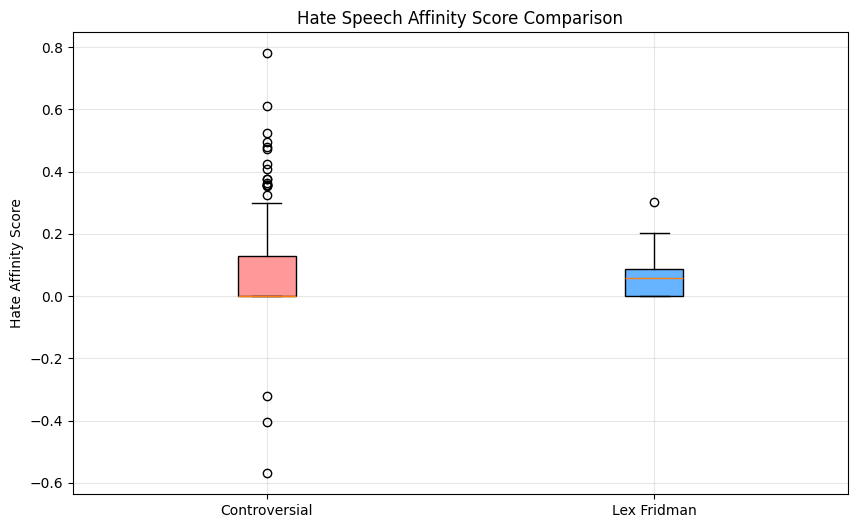

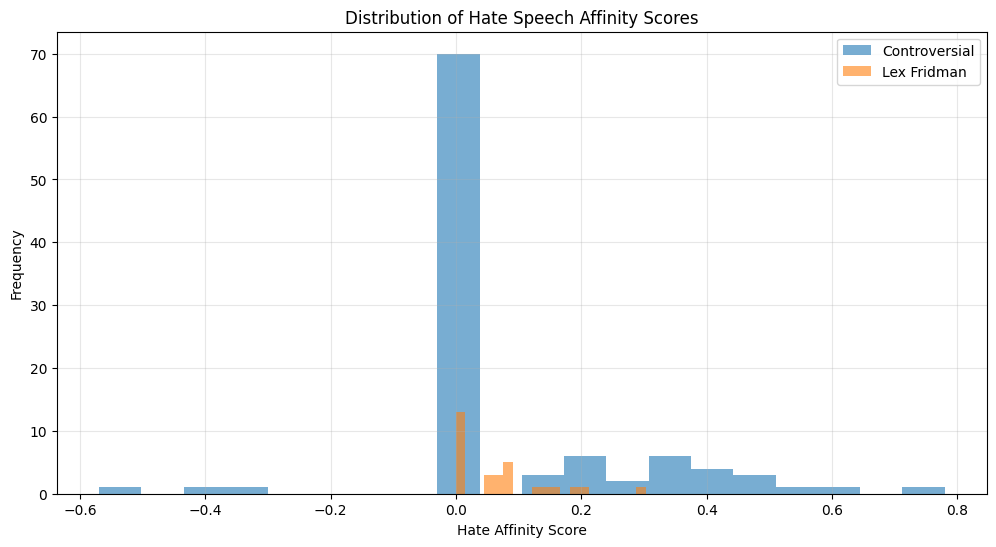


Statistics for hate affinity scores:

Controversial:
  Mean: 0.0796
  Median: 0.0000
  Std Dev: 0.1947
  Min: -0.5694
  Max: 0.7799

Lex Fridman:
  Mean: 0.0639
  Median: 0.0594
  Std Dev: 0.0754
  Min: 0.0000
  Max: 0.3032


In [14]:
# Create a comparison visualization of the hate affinity scores between the 2 pdocasts
import matplotlib.pyplot as plt
import numpy as np

# Save the dataframes to CSV files
episode_scores_df.to_csv("data/controversial_podcast.csv", index=False)
lex_episode_scores_df.to_csv("data/lex_fridman_episode_scores.csv", index=False)
print("Saved episode scores to CSV files:")
print("- controversial_podcast.csv")
print("- lex_fridman_episode_scores.csv")

# Create a combined dataset for comparison
controversial_scores = pd.DataFrame({
    'platform': ['Controversial'] * len(episode_scores_df),
    'hate_affinity_score': episode_scores_df['hate_affinity_score']
})

lex_scores = pd.DataFrame({
    'platform': ['Lex Fridman'] * len(lex_episode_scores_df),
    'hate_affinity_score': lex_episode_scores_df['hate_affinity_score']
})

all_scores = pd.concat([controversial_scores, lex_scores], ignore_index=True)
all_scores.to_csv("data/all_platform_scores.csv", index=False)
print("- all_platform_scores.csv")

# Create a boxplot comparison using matplotlib
plt.figure(figsize=(10, 6))

# Extract data for each platform
platforms = all_scores['platform'].unique()
data = [all_scores[all_scores['platform'] == platform]['hate_affinity_score'] for platform in platforms]

# Create box plot
box = plt.boxplot(data, patch_artist=True, labels=platforms)
colors = ['#ff9999', '#66b3ff']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Hate Speech Affinity Score Comparison')
plt.ylabel('Hate Affinity Score')
plt.grid(True, alpha=0.3)
plt.show()

# Create histograms to compare distributions
plt.figure(figsize=(12, 6))

# Extract data for each platform
for i, platform in enumerate(platforms):
    platform_data = all_scores[all_scores['platform'] == platform]['hate_affinity_score']
    plt.hist(platform_data, bins=20, alpha=0.6, label=platform)
    

plt.title('Distribution of Hate Speech Affinity Scores')
plt.xlabel('Hate Affinity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print statistics summary
print("\nStatistics for hate affinity scores:")
for platform in all_scores['platform'].unique():
    platform_scores = all_scores[all_scores['platform'] == platform]['hate_affinity_score']
    print(f"\n{platform}:")
    print(f"  Mean: {platform_scores.mean():.4f}")
    print(f"  Median: {platform_scores.median():.4f}")
    print(f"  Std Dev: {platform_scores.std():.4f}")
    print(f"  Min: {platform_scores.min():.4f}")
    print(f"  Max: {platform_scores.max():.4f}")

In [15]:
# Save segment-level scores to CSV files for further analysis
segment_scores_df.to_csv("data/controversial_segment_scores.csv", index=False)
lex_segment_scores_df.to_csv("data/lex_fridman_segment_scores.csv", index=False)

print("Saved segment-level scores to CSV files:")
print("- controversial_segment_scores.csv")
print("- lex_fridman_segment_scores.csv")

# Count high risk segments in both datasets (score > 0.5)
controversial_high_risk = len(segment_scores_df[segment_scores_df['score'] > 0.5])
lex_high_risk = len(lex_segment_scores_df[lex_segment_scores_df['score'] > 0.5])

print(f"\nHigh risk segments (score > 0.5):")
print(f"- Controversial: {controversial_high_risk} segments ({controversial_high_risk/len(segment_scores_df)*100:.2f}% of all segments)")
print(f"- Lex Fridman: {lex_high_risk} segments ({lex_high_risk/len(lex_segment_scores_df)*100:.2f}% of all segments)")

# Count medium risk segments (score between 0.1 and 0.5)
controversial_medium_risk = len(segment_scores_df[(segment_scores_df['score'] > 0.1) & (segment_scores_df['score'] <= 0.5)])
lex_medium_risk = len(lex_segment_scores_df[(lex_segment_scores_df['score'] > 0.1) & (lex_segment_scores_df['score'] <= 0.5)])

print(f"\nMedium risk segments (0.1 < score <= 0.5):")
print(f"- Controversial: {controversial_medium_risk} segments ({controversial_medium_risk/len(segment_scores_df)*100:.2f}% of all segments)")
print(f"- Lex Fridman: {lex_medium_risk} segments ({lex_medium_risk/len(lex_segment_scores_df)*100:.2f}% of all segments)")

Saved segment-level scores to CSV files:
- controversial_segment_scores.csv
- lex_fridman_segment_scores.csv

High risk segments (score > 0.5):
- Controversial: 0 segments (0.00% of all segments)
- Lex Fridman: 0 segments (0.00% of all segments)

Medium risk segments (0.1 < score <= 0.5):
- Controversial: 236 segments (8.64% of all segments)
- Lex Fridman: 67 segments (0.94% of all segments)


Saved all segment-level data to CSV files


/var/folders/ph/f73k11ns3_v8n6g3lrdb792w0000gr/T/ipykernel_89229/3057986402.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(segment_data, patch_artist=True, labels=platforms)


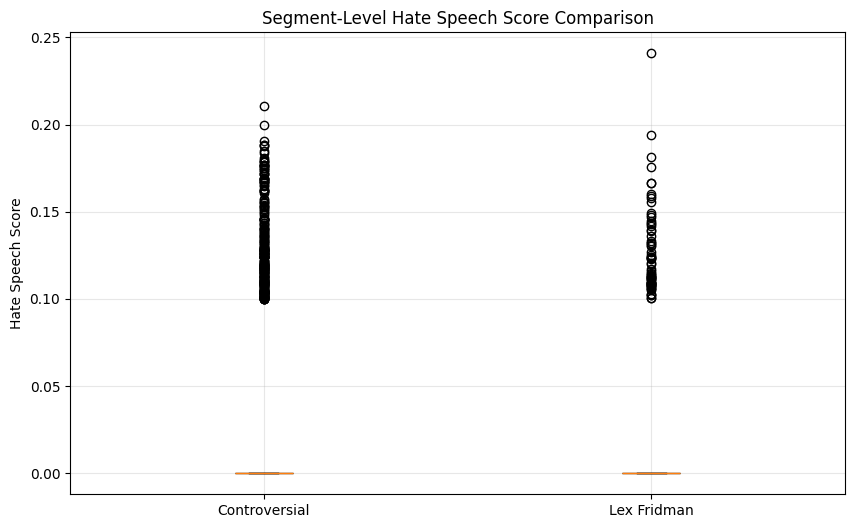

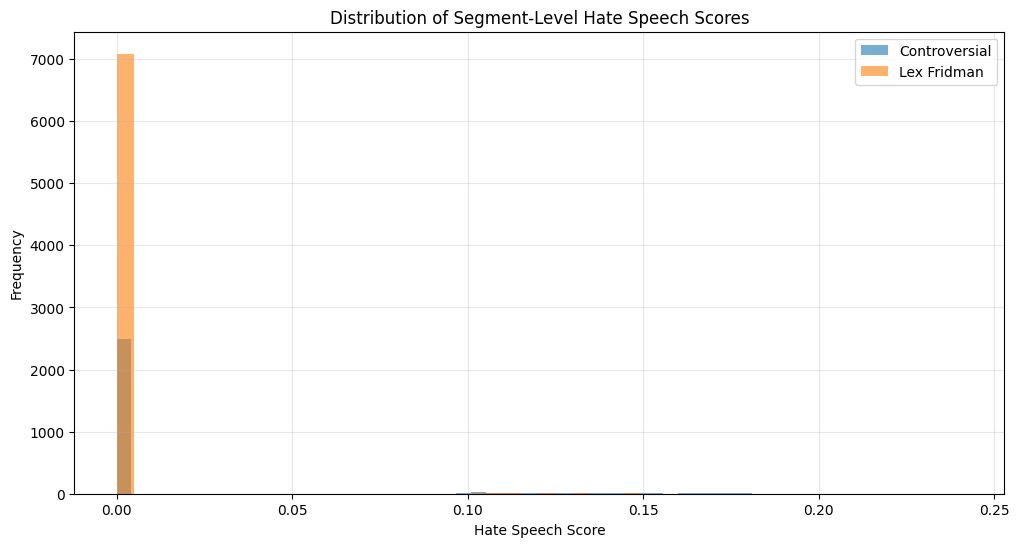

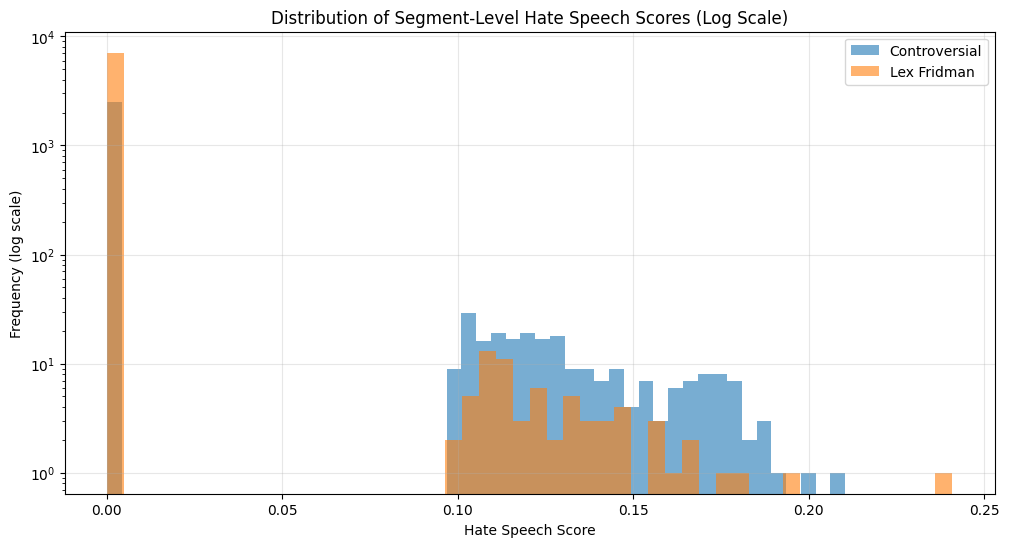

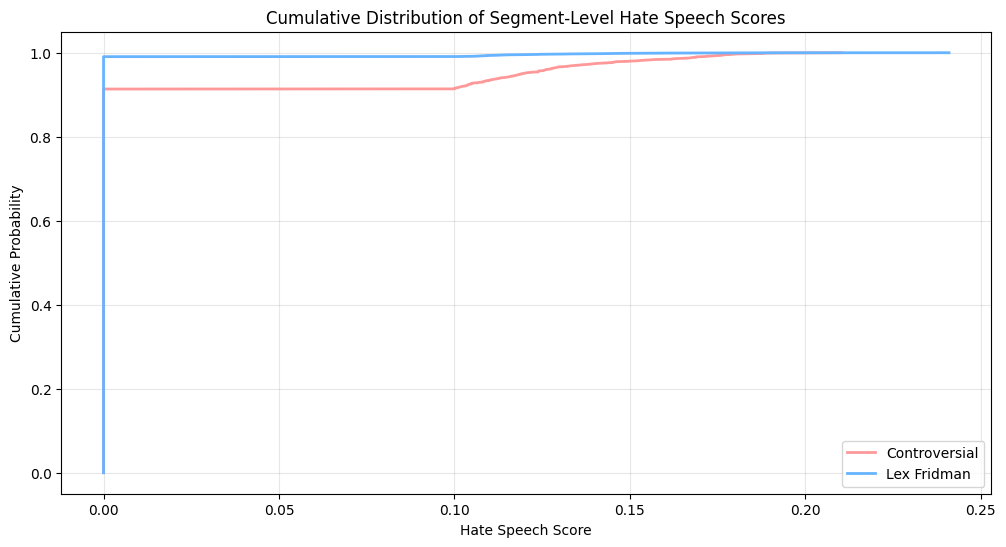


Segment-level statistics for hate speech scores:

Controversial:
  Count: 2731
  Mean: 0.0113
  Median: 0.0000
  Std Dev: 0.0376
  Min: 0.0000
  Max: 0.2104
  25th Percentile: 0.0000
  75th Percentile: 0.0000
  90th Percentile: 0.0000
  95th Percentile: 0.1193
  99th Percentile: 0.1689
  High risk segments (> 0.5): 0 (0.00%)
  Medium risk segments (0.1-0.5): 236 (8.64%)

Lex Fridman:
  Count: 7153
  Mean: 0.0012
  Median: 0.0000
  Std Dev: 0.0126
  Min: 0.0000
  Max: 0.2409
  25th Percentile: 0.0000
  75th Percentile: 0.0000
  90th Percentile: 0.0000
  95th Percentile: 0.0000
  99th Percentile: 0.0000
  High risk segments (> 0.5): 0 (0.00%)
  Medium risk segments (0.1-0.5): 67 (0.94%)


In [ ]:
# Create segment-level visualizations and comparisons
import matplotlib.pyplot as plt
import numpy as np

# Save the completed segment dataframes to CSV files
segment_scores_df.to_csv("data/controversial_segment_scores.csv", index=False)
lex_segment_scores_df.to_csv("data/lex_fridman_segment_scores.csv", index=False)

# Create dataframes with platform labels for combined analysis
controversial_segments = pd.DataFrame({
    'platform': ['Controversial'] * len(segment_scores_df),
    'score': segment_scores_df['score']
})

lex_segments = pd.DataFrame({
    'platform': ['Lex Fridman'] * len(lex_segment_scores_df),
    'score': lex_segment_scores_df['score']
})

# Combine segment scores
all_segment_scores = pd.concat([controversial_segments, lex_segments], ignore_index=True)
all_segment_scores.to_csv("data/all_segment_scores.csv", index=False)
print("Saved all segment-level data to CSV files")

# Create a boxplot comparison for segment-level scores
plt.figure(figsize=(10, 6))

# Extract data for each platform
platforms = all_segment_scores['platform'].unique()
segment_data = [all_segment_scores[all_segment_scores['platform'] == platform]['score'] for platform in platforms]

# Create box plot
box = plt.boxplot(segment_data, patch_artist=True, labels=platforms)
colors = ['#ff9999', '#66b3ff']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Segment-Level Hate Speech Score Comparison')
plt.ylabel('Hate Speech Score')
plt.grid(True, alpha=0.3)
plt.show()

# Create histograms to compare segment-level score distributions
plt.figure(figsize=(12, 6))

# Extract data for each platform
for i, platform in enumerate(platforms):
    platform_data = all_segment_scores[all_segment_scores['platform'] == platform]['score']
    # Plot histogram with log scale for y-axis to better see the distribution tail
    plt.hist(platform_data, bins=50, alpha=0.6, label=platform)

plt.title('Distribution of Segment-Level Hate Speech Scores')
plt.xlabel('Hate Speech Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Create a second histogram with log scale for better comparison of tails
plt.figure(figsize=(12, 6))
for i, platform in enumerate(platforms):
    platform_data = all_segment_scores[all_segment_scores['platform'] == platform]['score']
    # Plot histogram with log scale for y-axis
    plt.hist(platform_data, bins=50, alpha=0.6, label=platform)

plt.title('Distribution of Segment-Level Hate Speech Scores (Log Scale)')
plt.xlabel('Hate Speech Score')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Create cumulative distribution function (CDF) plot
plt.figure(figsize=(12, 6))
for i, platform in enumerate(platforms):
    platform_data = all_segment_scores[all_segment_scores['platform'] == platform]['score']
    # Sort the data
    sorted_data = np.sort(platform_data)
    # Get the cumulative probabilities
    p = 1. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    # Plot the CDF
    plt.plot(sorted_data, p, label=platform, color=colors[i], linewidth=2)

plt.title('Cumulative Distribution of Segment-Level Hate Speech Scores')
plt.xlabel('Hate Speech Score')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print detailed statistics for segment-level scores
print("\nSegment-level statistics for hate speech scores:")
for platform in all_segment_scores['platform'].unique():
    platform_scores = all_segment_scores[all_segment_scores['platform'] == platform]['score']
    print(f"\n{platform}:")
    print(f"  Count: {len(platform_scores)}")
    print(f"  Mean: {platform_scores.mean():.4f}")
    print(f"  Median: {platform_scores.median():.4f}")
    print(f"  Std Dev: {platform_scores.std():.4f}")
    print(f"  Min: {platform_scores.min():.4f}")
    print(f"  Max: {platform_scores.max():.4f}")
    print(f"  25th Percentile: {platform_scores.quantile(0.25):.4f}")
    print(f"  75th Percentile: {platform_scores.quantile(0.75):.4f}")
    print(f"  90th Percentile: {platform_scores.quantile(0.9):.4f}")
    print(f"  95th Percentile: {platform_scores.quantile(0.95):.4f}")
    print(f"  99th Percentile: {platform_scores.quantile(0.99):.4f}")
    
    # Count high and medium risk segments
    high_risk = len(platform_scores[platform_scores > 0.5])
    high_risk_pct = high_risk / len(platform_scores) * 100
    medium_risk = len(platform_scores[(platform_scores > 0.1) & (platform_scores <= 0.5)])
    medium_risk_pct = medium_risk / len(platform_scores) * 100
    
    print(f"  High risk segments (> 0.5): {high_risk} ({high_risk_pct:.2f}%)")
    print(f"  Medium risk segments (0.1-0.5): {medium_risk} ({medium_risk_pct:.2f}%)")


## Conclusion and Key Findings

In this notebook, we've built and evaluated a hate speech detection system using Sentinel with minimal training data. The key aspects of our approach include:

1. **Efficient Model Creation**: We constructed a hate speech detection model using only ~1,500 extremist quotes from SPLC as positive examples, balanced against ~15,000 neutral Lex Fridman podcast segments. This demonstrates Sentinel's ability to work effectively with limited training data.

2. **Cross-Dataset Evaluation**: By testing on a controversial podcast content (not seen during training) and comparing against Lex Fridman episodes, we validated the model's generalization capabilities and resistance to domain-specific biases.

3. **Multi-level Analysis**: We analyzed content at both segment level (individual text chunks) and episode level (aggregated scores using skewness), showing how patterns of concerning language emerge even when individual segments might not cross thresholds.

4. **Statistical Validation**: The distributions and percentile analysis demonstrate clear differentiation between the two content sources, with the other podcast showing significantly higher percentages of high-risk segments compared to Lex Fridman's podcast.

5. **Practical Application**: The CSV exports and visualization tools enable further analysis and potential integration into content moderation workflows.

This methodology showcases Sentinel's capability to detect rare class patterns in text with minimal examples, highlighting its potential for practical applications in online safety, content moderation, and harmful content detection across diverse platforms.

## Appendix: Detecting the "Wolf in Sheep's Clothes" - The Power of Skewness

Our analysis reveals an important pattern in how harmful content manifests across different sources, demonstrating Sentinel's ability to detect what we might call the "wolf in sheep's clothes" phenomenon.

### Understanding the Distribution Patterns

Looking at the segment-level histograms and statistics, we observe:

1. **Low Central Tendency in Both Sources**: Both Lex Fridman podcasts and the other podcast have segment score distributions with relatively low central tendency (mean/median) - the majority of content segments from both sources receive low hate speech scores.

2. **Critical Difference in Distribution Shape**: While both distributions have similar centers, the other podcast' distribution is notably **right-skewed with a heavy tail** - showing a relatively small number of highly toxic segments that score much higher than the average content.

3. **The "Hidden Toxicity" Problem**: This pattern represents a common challenge in content moderation - harmful content often appears as occasional "spikes" within otherwise benign material. Simple averaging methods would dilute these spikes, potentially missing concerning content.

### How Sentinel's Episode-Level Scoring Captures This Pattern

Sentinel's methodology effectively addresses this challenge through:

1. **Statistical Sensitivity to Skewness**: Rather than simple averaging, the episode-level scores account for distribution shape, giving higher weight to right-skewed distributions where even a few high-scoring segments exist.

2. **Capturing Rare but Significant Signals**: This approach successfully identifies content sources that occasionally "show their teeth" with harmful rhetoric, even when such rhetoric represents a small percentage of the total content.

3. **Practical Moderation Value**: The resulting episode-level scores place the other podcast episodes significantly higher than Lex Fridman episodes, creating a clear prioritization signal for content moderation efforts.

This approach demonstrates why robust hate speech detection requires attention not just to average content characteristics, but to distribution patterns that might reveal occasional but significant harmful content within otherwise unremarkable material.